In [1]:
%pylab inline
import sys; sys.path.insert(0, "../")
import numpy as np
import time

from pandas import DataFrame
import seaborn as sns

from emcee.autocorr import *
from ensemble_sampler import *

Populating the interactive namespace from numpy and matplotlib


# Example of sampling from a multivariate gaussian

## True distribution

In [2]:
dim = 2
nwalkers = 4
niters = 1000

In [3]:
mu = np.random.randn(dim)

cov = 0.5 - np.random.rand(dim ** 2).reshape((dim, dim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)

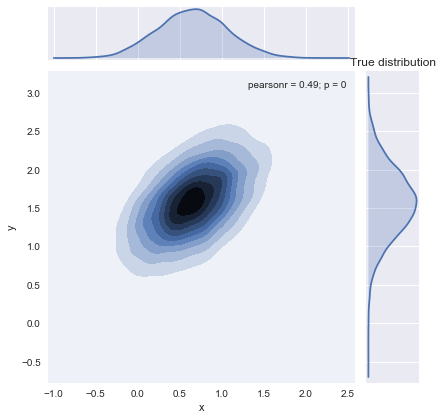

In [4]:
data = np.empty([10000, 2])
for i in range(10000):
    data[i] = np.random.multivariate_normal(mean=mu, cov=cov)
df = DataFrame(data, columns=['x', 'y'])
sns.jointplot(x='x', y='y', data=df, kind='kde')
sns.plt.title('True distribution')

## Only ensemble, proposal scale=0.5. 

In [5]:
save_dir = './data/'
title = 'ensemble_only'

In [6]:
proposal = WalkMove(scale=0.5)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
sampler.run_mcmc(niters, batch_size=1, p0=np.random.randn(dim*nwalkers).reshape([nwalkers, dim]), 
                verbose=False, store=True, save_dir=save_dir, title=title)
hist = sampler.history
end = time.time()

In [7]:
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

finishes in about 0.23 seconds
auto-correlation time: [  7.46860988  17.53026129]


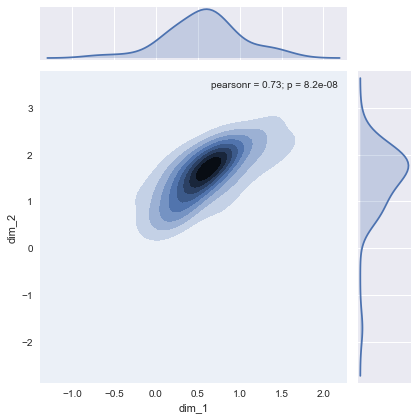

In [8]:
chain = hist.get_flat('chain')
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[::100, 0], chain[::100, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df, kind='kde')

## pCN, proposal beta=0.1. 

In [11]:
proposal = WalkMove(beta=0.4)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
hist = sampler.run_mcmc(niters, batch_size=1, random_start=True, store=True)

end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

finishes in about 0.26 seconds
auto-correlation time: [ 6.47901272  9.52947468]


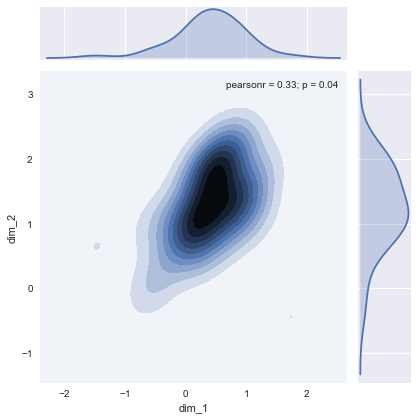

In [12]:
chain = sampler.history.get_flat('chain')
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[::100, 0], chain[::100, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df, kind='kde')

In [ ]:
from matplotlib.animation import FuncAnimation
proposal = WalkMove(beta=0.4)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)
hist = sampler.sample(niters, random_start=True, per_walker=False)

visualizer = Visualizer(sampler.history, False, max_len=niters)

In [14]:
anim = FuncAnimation(fig=visualizer.fig, func=visualizer, init_func=visualizer.init,
                     frames=hist, interval=20, blit=True, save_count=niters)

In [15]:
from IPython.display import HTML
HTML(anim.to_html5_video())

## "Pure pCN"

In [13]:
dim = 2
nwalkers = 4
niters = 100000

proposal = PCNWalkMove(s=None, beta=0.3)
sampler = Sampler(dim=dim, t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
sampler.run_mcmc(niters, batch_size=1, p0=np.random.randn(dim*nwalkers).reshape([nwalkers, dim]),
                 store=True, verbose=False, print_every=5000)
hist = sampler.history
end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

finishes in about 19.44 seconds
auto-correlation time: [ 14.1131529  16.3233293]


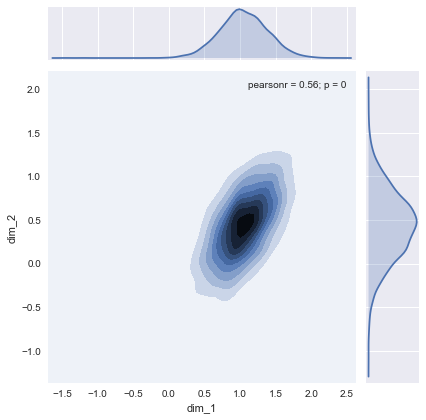

In [14]:
chain = hist.get_flat('chain')
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[::100, 0], chain[::100, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df, kind='kde')